In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Processes for Lyman-alpha

# Generate fake data

In [2]:
def lognormal_pdf(x, mu=0.2, sigma=1):
    """PDF of a lognormal distribution with a long tail (large sigma)."""
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))

z = np.linspace(0.001, 6, 500)
mean_nz = lognormal_pdf(z)

In [3]:
q = np.linspace(2, 4, 20)
data = [lognormal_pdf(_x) * (1 + 0.1 * np.random.normal())  for _x  in q]
errors = np.abs(np.random.normal(0, 0.015, len(data)))

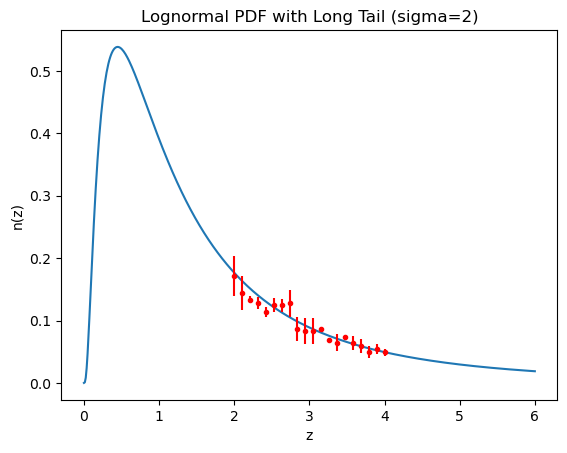

In [4]:
plt.plot(z, mean_nz)
plt.errorbar(q, data, yerr=errors, fmt='r.', label='Sampled Data')
plt.title('Lognormal PDF with Long Tail (sigma=2)')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.show()

## Set up GP

In [5]:
from scipy.spatial import distance_matrix


# Define the kernel of the GP
# i.e. our prior on noise properties of the gp
# In this case, we use a radial kernel
# which is a prior over Gaussian distributions
def radial_kernel(x, y=None, a=1, l=1):
    """Radial kernel function."""
    _x = np.array([[x_i] for x_i in x])
    if y is None:
        y = _x
    else:
        y = np.array([[y_i] for y_i in y])
    d = distance_matrix(_x, y)
    return a**2 * np.exp((-1/(2*l))*d**2)

# Set up the nodes at which we want to evaluate the kernel
# This will be positions of the free parameters of the GP
x = [2.2, 2.7, 3.2, 3.7]

# Select hyper-parameters for the kernel
# this is the same as fixing the prior
# Think of the kernel as the type of prior 
# and the hyper-parameters as the parameters of that prior
a = 0.2
l = 0.1

# Compute the kernel matrix for the nodes
# as well as at the data points and the mean function
kxx = radial_kernel(x, a=1, l=l)
kqx = radial_kernel(x, y=q, a=a, l=l)
kzx = radial_kernel(x, y=z, a=a, l=l)
print("kxx:", kxx.shape)
print("kqx:", kqx.shape)
print("kzx:", kzx.shape)

# We then want to compute the Cholesky decomposition of the kernel matrix
# at the nodes. We need this to transform samples from our latent variables
# into samples from the Gaussian process.
Lxx = np.linalg.cholesky(kxx)
print("Lxx:", Lxx.shape)

# Now we want to compute the Wienner filter that connects the GP
# evaluated at the nodes to the GP evaluated at the data points
# as well as the mean function.
# Note that the latter is not strictly necessary but it is useful
# for plotting the GP posterior.
# The Wiener filter is computed as follows:
# Wqx = kqx / Kxx
# Then using the Cholesky decomposition, we can compute it as:
# Wqx = kqx.T / (Lxx * Lxx.T)
# Where we can cancel one of the Lxx with the Lxx applied to the latent variables
# Thus Wqx now maps the latent variables to the data points directly.
Wqx = kqx.T @ np.linalg.inv(Lxx)
Wzx = kzx.T @ np.linalg.inv(Lxx)

kxx: (4, 4)
kqx: (4, 20)
kzx: (4, 500)
Lxx: (4, 4)


In [6]:
# Sample from the GP prior
nzs = [mean_nz + Wzx @ np.random.normal(size=len(x)) for i in range(1000)]
nzs_mean = np.mean(nzs, axis=0)
nzs_std = np.std(nzs, axis=0)

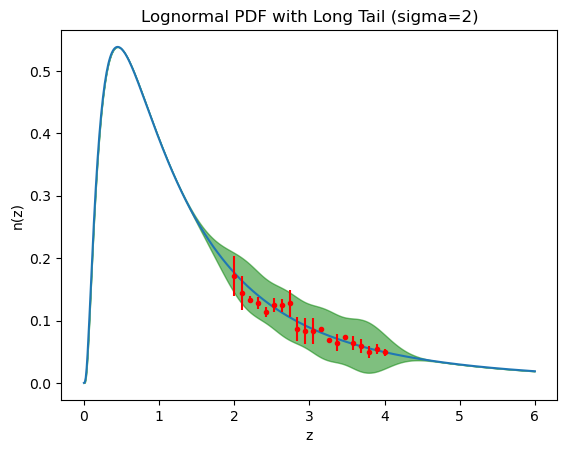

In [7]:
plt.plot(z, mean_nz)
plt.errorbar(q, data, yerr=errors, fmt='r.', label='Sampled Data')
plt.fill_between(z, nzs_mean - nzs_std, nzs_mean + nzs_std, color='green', alpha=0.5, label='Uncertainty Range')
plt.title('Lognormal PDF with Long Tail (sigma=2)')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.show()

## Fake Inference

In [8]:
# In order to set up an infernece we need to evaluate the GP at the data points
# note that alpha = np.random.normal(size=len(x)) is our 4 latent variables
nzs = np.array([lognormal_pdf(q) + Wqx @ np.random.normal(size=len(x)) for i in range(1000)])

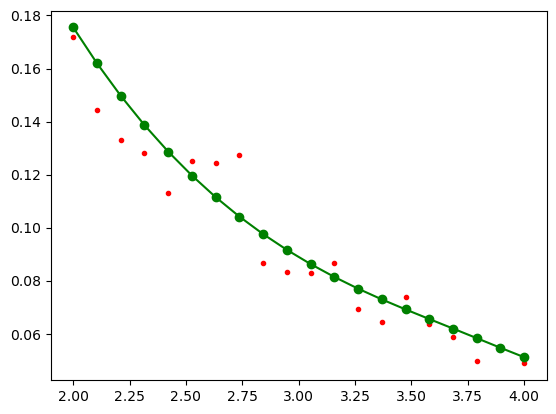

In [9]:
plt.plot(q, data, 'r.', label='Sampled Data')
plt.plot(q, np.mean(nzs, axis=0), 'go-', label='GP Mean');

In [10]:
# Now for the sake of example, let us come up with a posterior distribution on alpha
# and sample that to visualise the uncertainty in the GP posterior.
# The goal of the infernece should be to figure out the distribution of alpha from the data.
nzs = [mean_nz + Wzx @ ([0.65, -0.1, 0.1, -0.1] + 0.3*np.random.normal(size=len(x))) for i in range(1000)]
nzs_mean = np.mean(nzs, axis=0)
nzs_std = np.std(nzs, axis=0)

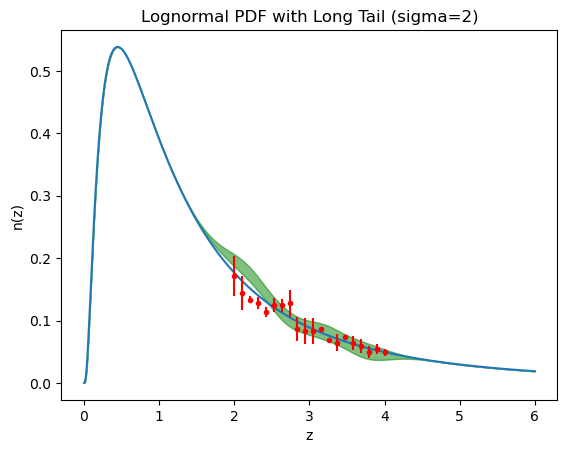

In [11]:
plt.plot(z, mean_nz)
plt.errorbar(q, data, yerr=errors, fmt='r.', label='Sampled Data')
plt.fill_between(z, nzs_mean - nzs_std, nzs_mean + nzs_std, color='green', alpha=0.5, label='Uncertainty Range')
plt.title('Lognormal PDF with Long Tail (sigma=2)')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.show()

# try to construct a GP model for the n(z)

In [82]:
import sys
sys.path.insert(0, "/global/homes/q/qhang/desi/lya/codes/")
import lya_utils as lu
from scipy import interpolate
from scipy.integrate import quad

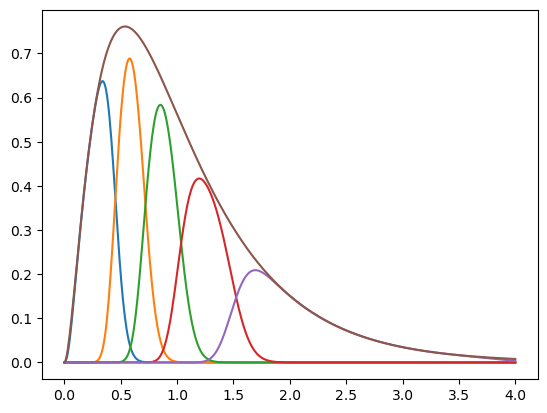

In [17]:
# generate nz of lsst source
n_bins=5
sigma_z = 0.05  # photo-z variance (scatter = 0.05 * (1 + z))
z_bias = 0
# compute srd n(z) for last bin:
redshift_range = np.linspace(0,4,500)
redshift_distribution = lu.srd_tot_nz(redshift_range)
srd_bins = lu.compute_equal_number_bounds(redshift_range, redshift_distribution, n_bins)

# Loop over the bins: each bin is defined by the upper and lower edge of the bin
lsst_nz = np.zeros((len(redshift_range), n_bins))
for ii in range(n_bins):
    x1 = srd_bins[ii]
    x2 = srd_bins[ii+1]
    lsst_nz[:,ii] = lu.true_redshift_distribution(x1, x2, sigma_z, z_bias, 
                                                  redshift_range, redshift_distribution)
    #useind = redshift_range<3
    #target_nz = np.c_[redshift_range[useind], source_nz[useind]]
    plt.plot(redshift_range, lsst_nz[:,ii])
plt.plot(redshift_range, redshift_distribution)

In [100]:
z = redshift_range
mean_nz = lsst_nz[:,4]/sum(lsst_nz[:,4])/(z[1]-z[0])
nz_funct = interpolate.interp1d(z,mean_nz,fill_value=0,bounds_error=False)

In [101]:
q = np.linspace(2.025, 2.975, 20)
data = [nz_funct(_x) * (1 + 0.1 * np.random.normal())  for _x  in q]
errors = np.abs(np.random.normal(0, 0.015, len(data)))

In [117]:
# Set up the nodes at which we want to evaluate the kernel
# This will be positions of the free parameters of the GP
x = [2.3, 2.5, 2.7]

# Select hyper-parameters for the kernel
# this is the same as fixing the prior
# Think of the kernel as the type of prior 
# and the hyper-parameters as the parameters of that prior
a = 0.3
l = 0.05

# Compute the kernel matrix for the nodes
# as well as at the data points and the mean function
kxx = radial_kernel(x, a=1, l=l)
kqx = radial_kernel(x, y=q, a=a, l=l)
kzx = radial_kernel(x, y=z, a=a, l=l)
print("kxx:", kxx.shape)
print("kqx:", kqx.shape)
print("kzx:", kzx.shape)

# We then want to compute the Cholesky decomposition of the kernel matrix
# at the nodes. We need this to transform samples from our latent variables
# into samples from the Gaussian process.
Lxx = np.linalg.cholesky(kxx)
print("Lxx:", Lxx.shape)

# Now we want to compute the Wienner filter that connects the GP
# evaluated at the nodes to the GP evaluated at the data points
# as well as the mean function.
# Note that the latter is not strictly necessary but it is useful
# for plotting the GP posterior.
# The Wiener filter is computed as follows:
# Wqx = kqx / Kxx
# Then using the Cholesky decomposition, we can compute it as:
# Wqx = kqx.T / (Lxx * Lxx.T)
# Where we can cancel one of the Lxx with the Lxx applied to the latent variables
# Thus Wqx now maps the latent variables 
Wqx = kqx.T @ np.linalg.inv(Lxx)
Wzx = kzx.T @ np.linalg.inv(Lxx)

kxx: (3, 3)
kqx: (3, 20)
kzx: (3, 500)
Lxx: (3, 3)


In [118]:
# Sample from the GP prior
nzs = [mean_nz + Wzx @ np.random.normal(size=len(x)) for i in range(1000)]
nzs_mean = np.mean(nzs, axis=0)
nzs_std = np.std(nzs, axis=0)

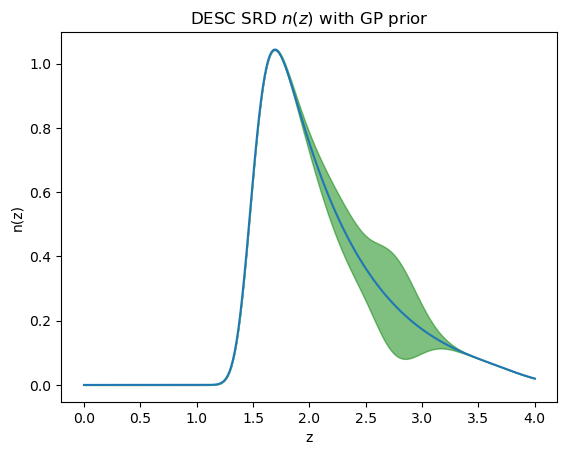

In [128]:
plt.plot(z, mean_nz)
#plt.errorbar(q, data, yerr=errors, fmt='r.', label='Sampled Data')
plt.fill_between(z, nzs_mean - nzs_std, nzs_mean + nzs_std, color='green', alpha=0.5, label='Uncertainty Range')
plt.title('DESC SRD $n(z)$ with GP prior')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.show()

In [120]:
# can we propagate this to w_sp? Let's try
yaw_tag="-20bin"
sim_num=0
outroot="/pscratch/sd/q/qhang/desi-lya/results-newbias/"
saveroot = outroot + f"run-{sim_num}/yaw{yaw_tag}/inference/"
model_root = saveroot + "model/"

# load model files:
model_prefix = "wsp_int_known_bg_linear_theta_23_50"
zgrid=np.loadtxt(model_root + f"{model_prefix}.zgrid.txt")
Nzbins=int(yaw_tag[1:-3])

zbin_edges = np.linspace(2,3,Nzbins+1)
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2.
if Nzbins>=20:
    meanz = meanz[:-1] # let's exclude the last bin in >= 20 bin case as it is not well measured

alpha=0.0
wsp_int1_thetacomb=np.loadtxt(model_root + f"{model_prefix}.thetacomb_alpha-{alpha}_int.txt")
    
# load data, covariance:
#data_root = saveroot + "../" # assume data is in the same directory
#wsp_measure = np.loadtxt(data_root + args.data_file)
#data = wsp_measure
#if Nzbins>=20:
#    data = data[:-1,0]

#if args.cov_file == "":
#    cov = np.cov(wsp_measure[:-1,2:])*njn
#    njn = len(wsp_measure[0,2:])
#else:
#    cov = np.loadtxt(data_root + args.cov_file)

#nz_file = np.loadtxt(args.true_nz_path)
#nz_gal_law = interpolate.interp1d(nz_file[:,0],nz_file[:,1],fill_value=0,bounds_error=False)

# this does the integral for the unknown n(z), and is what we will call in MCMC
def wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim):
    """
    w_z_func: the function that computes the wsp at various z of the unknown sample
    nz_law_unk: unknown redshift distribution function
    zlim: integration limit of the function
    """
    
    zmin = zlim[0]
    zmax = zlim[1]
    
    def integrate_z2(z):
        return nz_law_unk(z)*w_z_func(z)
    
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

# define model and likelihood functions here:
def compute_wsp(nz_law_unk, x):
    zlim = [1.8,3.0]
    model = np.zeros(len(x))

    for jj, z_ref in enumerate(x):
        fw = wsp_int1_thetacomb[jj,:]
        w_z_func = interpolate.interp1d(zgrid, fw)
        model[jj] = wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim)
    return model

In [121]:
len(nzs)

1000

In [122]:
wsp = []
for ii in range(len(nzs)):
    nz_law_unk = interpolate.interp1d(z,nzs[ii],fill_value=0,bounds_error=False)
    wsp.append(compute_wsp(nz_law_unk, meanz))

In [123]:
wsp_th = compute_wsp(nz_funct, meanz)

In [124]:
wsps_mean = np.mean(wsp, axis=0)
wsps_std = np.std(wsp, axis=0)

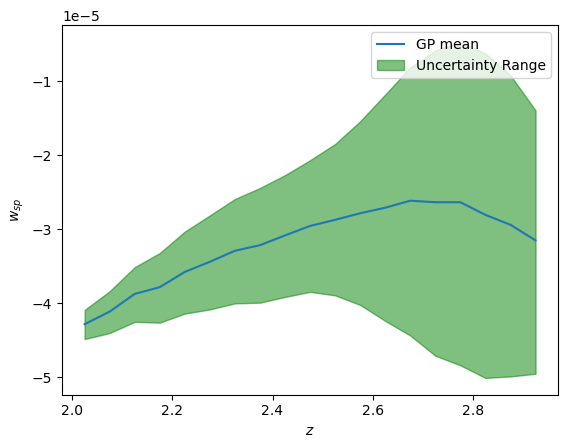

In [126]:
plt.plot(meanz, wsp_th,label="GP mean")
plt.fill_between(meanz, wsps_mean - wsps_std, wsps_mean + wsps_std, color='green', alpha=0.5, label='Uncertainty Range')
plt.xlabel("$z$")
plt.ylabel("$w_{sp}$")
plt.legend()